# Transfer Learning

## Download the Pre-trained Model


In [1]:
# Download the pre-trained weights. No top means it excludes the fully connected layer it uses for classification.
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2023-06-03 11:24:18--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.128, 142.251.120.128, 142.251.161.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   272MB/s    in 0.3s    

2023-06-03 11:24:18 (272 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



## Define Directory and Setup The Pretrained Model

In [2]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers

# Set the weights file you downloaded into a variable
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# Initialize the base model.
# Set the input shape and remove the dense layers.
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

# Load the pre-trained weights you downloaded.
pre_trained_model.load_weights(local_weights_file)

# Freeze the weights of the layers.
for layer in pre_trained_model.layers:
  layer.trainable = False

In [3]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                       

In [4]:
# Choose `mixed_7` as the last layer of your base model
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Add Dense Layers For Classifier

In [6]:
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense(1, activation='sigmoid')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                            

In [7]:
# Set the training parameters
model.compile(optimizer = RMSprop(learning_rate=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

## Prepare the Dataset

In [8]:
# Download the dataset
!wget https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip

--2023-06-03 11:44:46--  https://storage.googleapis.com/tensorflow-1-public/course2/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.74.128, 173.194.192.128, 209.85.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.74.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   246MB/s    in 0.3s    

2023-06-03 11:44:46 (246 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [9]:
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Extract the archive
zip_ref = zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

# Define our example directories and files
base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')

# Directory with training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats') 

# Directory with training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') 

# Directory with validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') 

# Directory with validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## Train The Model

In [10]:
# Train the model.
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 20,
            validation_steps = 50,
            verbose = 2)

Epoch 1/20
100/100 - 35s - loss: 0.3101 - accuracy: 0.8710 - val_loss: 0.1159 - val_accuracy: 0.9530 - 35s/epoch - 349ms/step
Epoch 2/20
100/100 - 21s - loss: 0.2043 - accuracy: 0.9165 - val_loss: 0.0916 - val_accuracy: 0.9680 - 21s/epoch - 212ms/step
Epoch 3/20
100/100 - 19s - loss: 0.2067 - accuracy: 0.9235 - val_loss: 0.1322 - val_accuracy: 0.9490 - 19s/epoch - 192ms/step
Epoch 4/20
100/100 - 20s - loss: 0.1751 - accuracy: 0.9325 - val_loss: 0.1152 - val_accuracy: 0.9550 - 20s/epoch - 202ms/step
Epoch 5/20
100/100 - 19s - loss: 0.1513 - accuracy: 0.9450 - val_loss: 0.0819 - val_accuracy: 0.9670 - 19s/epoch - 191ms/step
Epoch 6/20
100/100 - 20s - loss: 0.1613 - accuracy: 0.9385 - val_loss: 0.0844 - val_accuracy: 0.9710 - 20s/epoch - 205ms/step
Epoch 7/20
100/100 - 19s - loss: 0.1536 - accuracy: 0.9420 - val_loss: 0.1668 - val_accuracy: 0.9480 - 19s/epoch - 192ms/step
Epoch 8/20
100/100 - 20s - loss: 0.1387 - accuracy: 0.9485 - val_loss: 0.0964 - val_accuracy: 0.9610 - 20s/epoch - 204

## Evaluate The Results

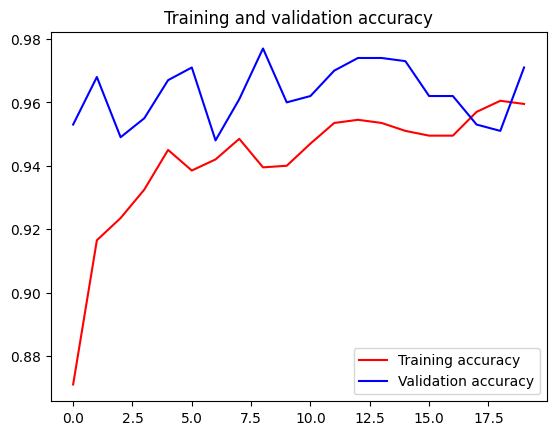

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()


plt.show()